# **Disentangled Representational Learning of Single Lead Electrocardiogram Signals using Variational Autoencoder**

This notebook evaluates the properties and accuracy of the trained VECG model in several aspects. The structure follows the three main objectives:

1. investigation of **Disentanglement**
2. evaluation of **Anomaly Detection** accuracy and explainability
3. improvements through the use of **Personalization**

The results are summarized in a corresponding article, which the authors ask to be cited when using the results of this work.

## General

This section of for imports, getting an overview of all experiments, and loading the most suitable model.

In [1]:
import sys
import os
import warnings
import logging
from absl import logging as absl_logging

os.environ['TFDS_DATA_DIR'] = "/mnt/sdb/home/ml/tensorflow_datasets/"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
absl_logging.set_verbosity(absl_logging.ERROR)

from src.utils.helper import Helper
from src.evaluate.visualizations import Visualizations

import tensorflow as tf
import pandas as pd
import numpy as np
import glob
from neurokit2.signal import signal_smooth

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
from matplotlib import pyplot as plt
import seaborn as sns

2024-10-15 22:34:10.827461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 22:34:10.827495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 22:34:10.828501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 22:34:11.277104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# The resolution for saving images
DPI = 300

# The source path of the experiments and models
PATH = '../results/run_3/'

# Some operations take some time in computation.
# Therefore, the stored intermediate results can be used to skip the respective computation.
USE_PRECOMPUTED = True

Whenever a dataset is used within this work, e.g., for loading or embedding, it needs to be declared as a dictionary. The keys are a name (array of datasets to be loaded), the split, the shuffle size, and the batch size.

In [3]:
datasets = {
    'name': ['synth:1.0.9'],
    'split': 'train',
    'shuffle_size': 1024,
    'batch_size': 1024,
}

All models and their performance indicators during training are loaded, and the mututal information gap (MIG) is calculated based on the provided dataset. The experiment(..) function returns a Pandas data frame, which is then sorted based on the MIG score to select the best fitting model.

In [4]:
df = Helper.experiments(datasets, path=PATH)

8/8 [==============================] - 0s 18ms/step


In [5]:
df.sort_values(by=['MIG', 'latent_dim', 'alpha', 'beta', 'gamma']).tail()

alpha  beta  gamma       loss      recon        mi         tc       dw_kl  \
20   0.10  0.40   0.10  48.470100  36.008671  6.028219   5.691223   95.821205   
1    0.05  0.20   0.05  45.650776  35.361412  6.049183   6.335815  174.394806   
12   0.05  0.20   0.05  42.267979  31.454027  6.198841   9.961824  170.232880   
29   0.01  0.04   0.01  32.668133  25.632713  6.244719  21.661219  610.652344   
7    0.20  0.80   0.20  59.269009  42.384178  5.845186   3.607689   64.148209   

                  time  latent_dim  epoch       total       MIG  
20 2024-02-17 10:33:08          12     79  143.549317  0.184045  
1  2024-02-16 00:28:47           8    107  222.141216  0.186104  
12 2024-02-16 20:15:23          20     79  217.847572  0.215449  
29 2024-02-17 21:32:01          24    135  664.190995  0.219615  
7  2024-02-16 15:25:04          12     79  115.985262  0.234189

The suggested model is loaded based on the sorting. However, other models can also be selected in the drop-down menu in order to evaluate them.

In [6]:
val = Helper.select_path(PATH)

In [7]:
val

Dropdown(description='Base path:', options=('../results/run_3/2024-02-15_23-13-43/', '../results/run_3/2024-02…

In [8]:
#path_base = val.value + '/'
path_base = PATH + '2024-02-16_15-25-04/'
path_model = path_base + 'model_best/'
model = tf.keras.models.load_model(path_model)
params = Helper.load_yaml_file(path_base + 'params.json')

## 1. Disentanglement

The property of disentanglement is evaluated on the SYNECG, Medalcare, and CU-SPH (zheng) dataset. Therefore, we need the respective embeddings.

In [9]:
datasets = {
    'name': ['synth:1.0.9', 'synth:1.0.11', 'medalcare', 'zheng'],
    'split': 'train',
    'shuffle_size': 1024,
    'batch_size': 1024,
}
embeddings, ld = Helper.get_embeddings(model, datasets)

131/131 [==============================] - 5s 37ms/step


The axis-feature relationship is calculated using the coefficient of determination ($R^2$) from a one-dimensional linear regression. A higher predictability (score) is assumed to be a higher association of a dimension with a feature. In addition, a large gap between the first score and the associated feature to the second highest recognized feature indicates a higher degree of disentanglement, as it indicates that only one feature is encoded along the axis. Both a tabular and a visual representation are shown.

In [10]:
struct = Helper.feature_axis_mapping(embeddings, ld)
interpretation = Helper.readable_axis_mapping(struct)

In [11]:
Visualizations.print_axis_interpretation(interpretation)

Dimension             Feature_0          Feature_1          Feature_2  \
0         0     p_height: 0.33736   t_height: 0.2895    r_width: 0.2251   
0         1     p_height: 0.47015  p_height: 0.06738    p_angle: 0.0624   
0         2      r_width: 0.21962       age: 0.09722  t_height: 0.07048   
0         3     p_height: 0.82414   r_width: 0.24897     v_LA.z: 0.1448   
0         4      s_width: 0.29907   q_width: 0.15495  t_height: 0.15408   
0         5     p_height: 0.49542   p_width: 0.23605    v_RL.z: 0.08753   
0         6      r_width: 0.39818  p_height: 0.32707    v_LA.z: 0.17032   
0         7     t_height: 0.89084  t_height: 0.29439   p_width: 0.26556   
0         8      p_height: 0.5763  p_height: 0.16058  t_height: 0.16034   
0         9     t_height: 0.26483   p_width: 0.21262   r_width: 0.13141   
0        10  qt_interval: 0.13607  t_offset: 0.11994  p_height: 0.07818   
0        11     p_height: 0.41909   p_height: 0.1915   s_width: 0.10511   

                   Feature_3  
0           s_width: 0.14039  
0           q_width: 0.04142  
0           q_width: 0.06194  
0          p_height: 0.14431  
0           r_width: 0.13616  
0            v_RA.z: 0.08584  
0            v_V4.z: 0.15251  
0  ventricular_rate: 0.26075  
0           p_angle: 0.07372  
0      qrs_duration: 0.12187  
0         qrs_count: 0.07422  
0          t_height: 0.09619

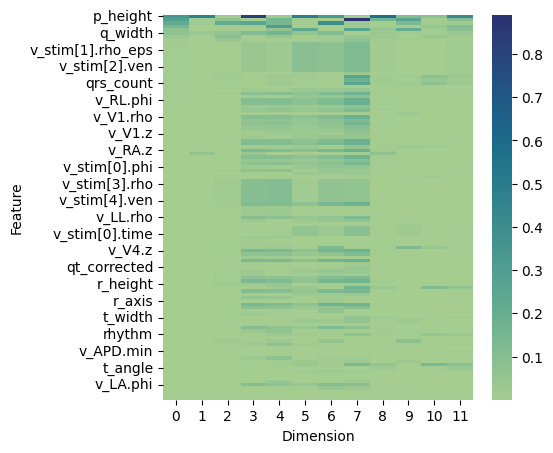

In [12]:
Visualizations.plot_axis_relation(interpretation, ld, save_path='../analysis/media/axis_feature_corrplot_axis_relationelation.png', dpi=DPI)

We want to investigate how the features with the highest axis relation are distributed and whether they have a orthogonal structure, which would indicate disentanglement.

In [13]:
plt.rcParams['font.size'] = 14

<Figure size 346.457x259.843 with 0 Axes>

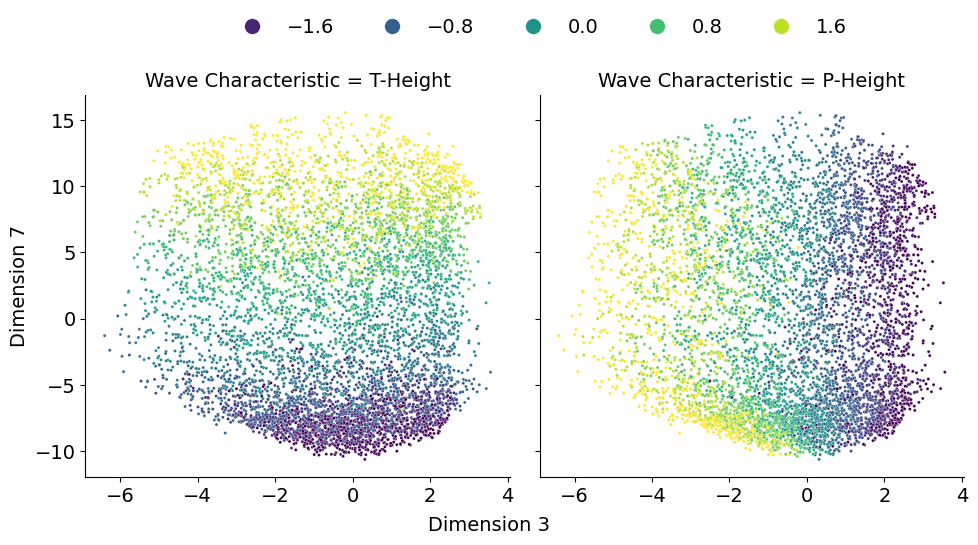

In [14]:
Visualizations.plot_scatter(embeddings[0], 3, 7, 't_height', 'p_height', 'T-Height', 'P-Height', DPI, path_save='../analysis/media/embedding_synthetic.png')

To evaluate the effects of switching certain dimensions in the embedding, reconstruction plots are created. The reconstructions are created based on VAE priority (i.e. $\vec{0}$) and only one dimension is changed in the range of -15 to 15. The visual inspection shows whether only one particular feature is affected or several. For illustration purposes, the title of the diagram is set to the characteristics and the corresponding $R^2$ values of the previous calculation.

In [15]:
# Adaptation of the interpretations (based on the table above) to make them look more trendy and accessible in the final presentation.
# We also add the expert assessment of the changes seen in the ECG.
interpretation = {
    "Dim 0": {
        "Features": ["P-wave height"],
        "Scores": [0.33736],
        "Rater": ["Mode collapse"],
    },
    "Dim 1": {
        "Features": ["P-wave height"],
        "Scores": [0.47015],
        "Rater": ["P-wave height", "PQ interval"],
    },
    "Dim 2": {
        "Features": ["R-peak width"],
        "Scores": [0.21962],
        "Rater": ["Mode collapse"],
    },
    "Dim 3": {
        "Features": ["P-wave height"],
        "Scores": [0.82414],
        "Rater": ["P-wave height", "Q-wave width"],
    },
    "Dim 4": {
        "Features": ["S-wave width"],
        "Scores": [0.29907],
        "Rater": ["Baseline", "S-wave width"],
    },
    "Dim 5": {
        "Features": ["P-wave height and width"],
        "Scores": [0.49542],
        "Rater": ["Redundant to Dimension 7"],
    },
    "Dim 6": {
        "Features": ["R-peak width"],
        "Scores": [0.39818],
        "Rater": ["QRS-width", "P-wave height"],
    },
    "Dim 7": {
        "Features": ["T-wave height"],
        "Scores": [0.89084],
        "Rater": ["T-wave height"],
    },
    "Dim 8": {
        "Features": ["P-wave height", "", ""],
        "Scores": [0.5763],
        "Rater": ["Unclear"],
    },
    "Dim 9": {
        "Features": ["T-wave height", "", ""],
        "Scores": [0.26483],
        "Rater": ["P-wave height", "Q-wave width", "ST-segment"],
    },
    "Dim 10": {
        "Features": ["QT interval", "", ""],
        "Scores": [0.13607],
        "Rater": ["ST segment", "QT-interval"],
    },
    "Dim 11": {
        "Features": ["P-wave height"],
        "Scores": [0.41909],
        "Rater": ["T-wave height", "QT-interval"],
    }
}

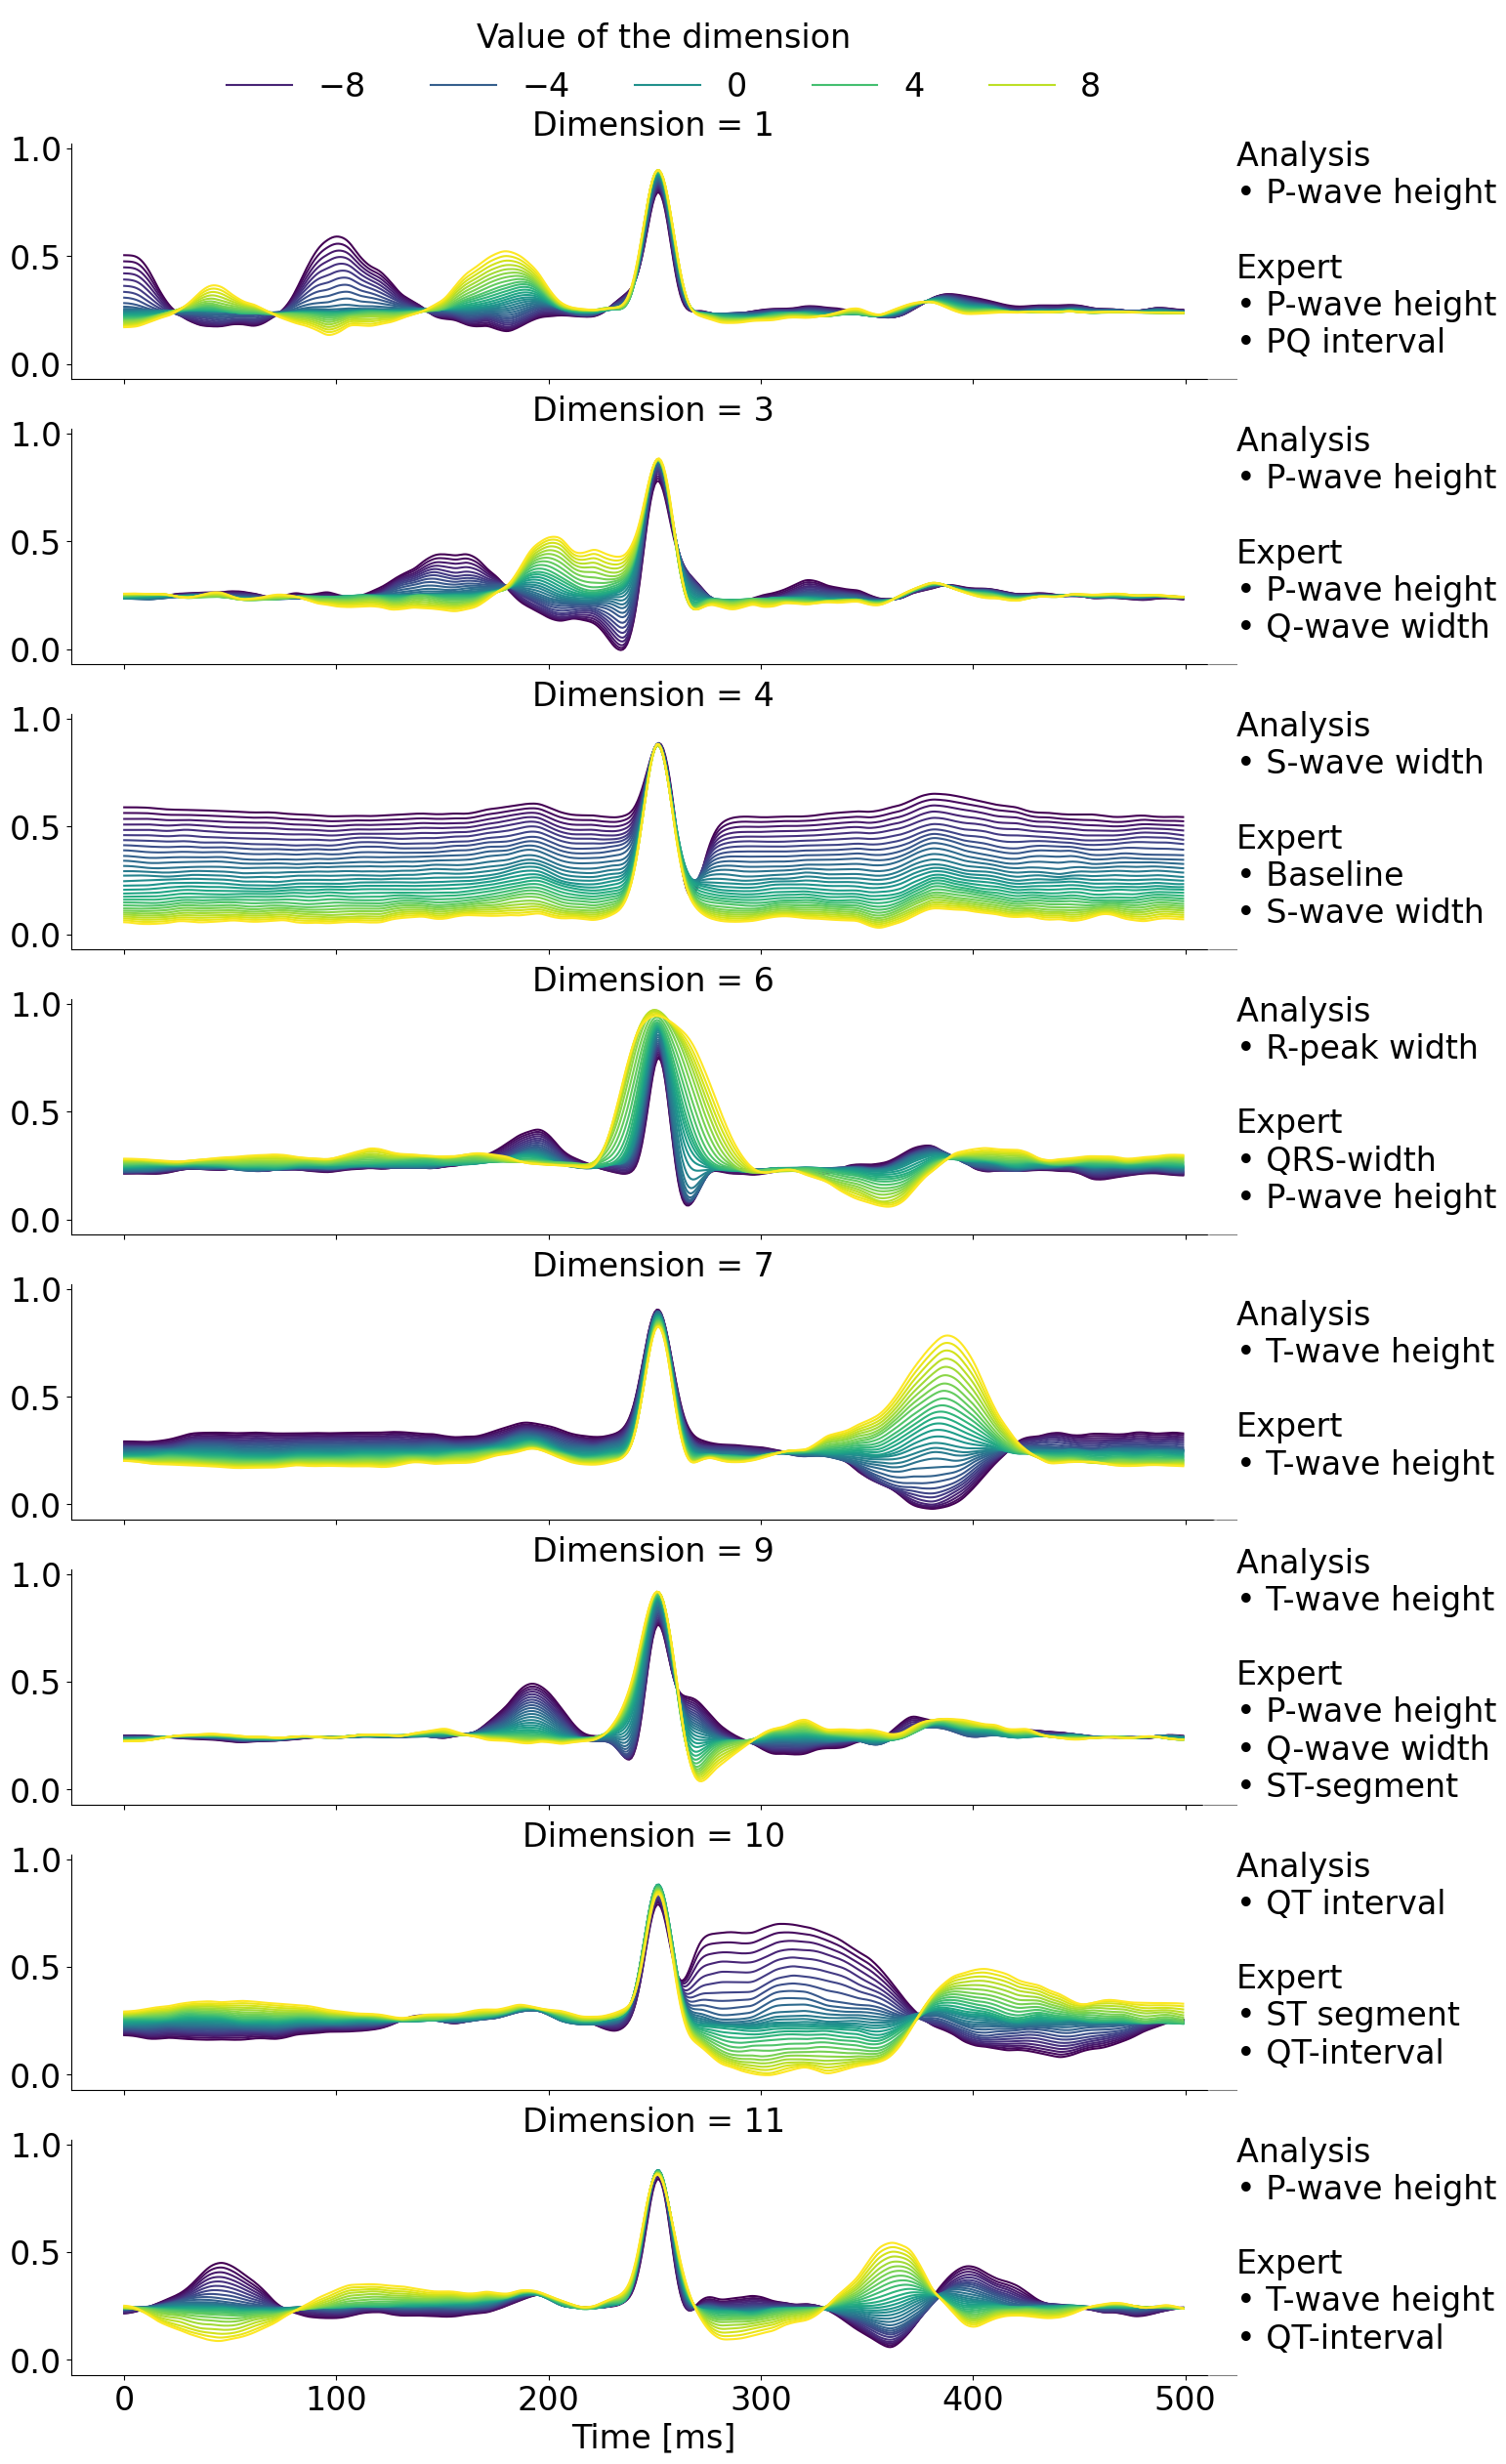

In [16]:
plt.rcParams['font.size'] = 24
x_values = list(np.linspace(-10.0, 10.0, 30))
path = '../analysis/media/'
dimensions=[1, 3, 4, 6, 7, 9, 10, 11]

Visualizations.plot_with_facetgrid(ld, x_values, path, model, interpretation, DPI, dimensions)

In [17]:
widgets.interact(Visualizations.reconstruct, dim=range(0, ld), x=(-100.0, 100.0, 0.5), model=[model], ld=[ld])

interactive(children=(Dropdown(description='dim', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=0), Fl…

<function src.evaluate.visualizations.Visualizations.reconstruct(dim, x, model, ld)>

# 2. Anomaly Detection

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Medalcare

### Data Preparation

The consecutive steps are:

1. Loading the Medalcare train, validation, and test data set
2. Embedding the data sets
3. Excluding the non-relevant pathologies, i.e., LAE, ICB, FAC
4. Preparing the matrix and their associated binary and multiclass labels

In [19]:
dataset_medalcare_train = {'name': ['medalcare:1.0.5'], 'split': 'train', 'shuffle_size': 1024, 'batch_size': 1024}
dataset_medalcare_validation = {'name': ['medalcare:1.0.5'], 'split': 'validation', 'shuffle_size': 1024, 'batch_size': 1024}
dataset_medalcare_test = {'name': ['medalcare:1.0.5'], 'split': 'test', 'shuffle_size': 1024, 'batch_size': 1024}

In [20]:
df_medalcare_train, ld = Helper.get_embeddings(model, dataset_medalcare_train)
df_medalcare_validation, _ = Helper.get_embeddings(model, dataset_medalcare_validation)
df_medalcare_test, _ = Helper.get_embeddings(model, dataset_medalcare_test)

28/28 [==============================] - 3s 113ms/step


In [21]:
def number_to_category(df):
    df.diagnosis = df.diagnosis.replace(0.0, 'avblock').replace(1.0, 'fam').replace(
        2.0, 'iab').replace(3.0, 'lae').replace(4.0, 'lbbb').replace(
        5.0, 'mi').replace(6.0, 'rbbb').replace(7.0, 'sinus')
    df.subdiagnosis = df.subdiagnosis.replace(0.0, '').replace(1.0, 'examples').replace(
        2.0, 'LAD').replace(3.0, 'LAD').replace(4.0, 'LCX').replace(
        5.0, 'LCX').replace(6.0, 'LCX').replace(7.0, 'LCX').replace(
        8.0, 'RCA').replace(9.0, 'RCA')    
    df.diagnosis = df.diagnosis + df.subdiagnosis
    
    return df

In [22]:
df_medalcare_train = number_to_category(df_medalcare_train[0])
df_medalcare_validation = number_to_category(df_medalcare_validation[0])
df_medalcare_test = number_to_category(df_medalcare_test[0])

In [24]:
df_medalcare_train['diagnosis_binary'] = df_medalcare_train.diagnosis != 'sinus'
df_medalcare_validation['diagnosis_binary'] = df_medalcare_validation.diagnosis != 'sinus'
df_medalcare_test['diagnosis_binary'] = df_medalcare_test.diagnosis != 'sinus'

In [25]:
include = ['avblock', 'lbbb', 'miLCX', 'rbbb', 'sinus']

In [26]:
X_train, y_train, y_train_b  = df_medalcare_train[df_medalcare_train.diagnosis.isin(include)].iloc[:, 0:ld], df_medalcare_train[df_medalcare_train.diagnosis.isin(include)]['diagnosis'], df_medalcare_train[df_medalcare_train.diagnosis.isin(include)]['diagnosis_binary']
X_val, y_val, y_val_b = df_medalcare_validation[df_medalcare_validation.diagnosis.isin(include)].iloc[:, 0:ld], df_medalcare_validation[df_medalcare_validation.diagnosis.isin(include)]['diagnosis'], df_medalcare_validation[df_medalcare_validation.diagnosis.isin(include)]['diagnosis_binary']
X_test, y_test, y_test_b  = df_medalcare_test[df_medalcare_test.diagnosis.isin(include)].iloc[:, 0:ld], df_medalcare_test[df_medalcare_test.diagnosis.isin(include)]['diagnosis'], df_medalcare_test[df_medalcare_test.diagnosis.isin(include)]['diagnosis_binary']

### Multiclass

For the multi-class prediction, i.e. the separation of the classes "sinus", "rbbb", "lbbb" and "avblock", we used the k-nearest neighbor classification. The hyperparameter $k$ was determined using the Medalcare validation dataset as a cross-validation set. The best result $k$ was then used to train the kNN classifier based on the Medalcare training dataset and on the Medalcare test dataset that had never been used before (i.e. it was never included in any training process, neither in the VAE nor in the kNN process).

In [27]:
best_k = Helper.cross_validation_knn(X_train, X_val, y_train, y_val)

Best k: 39 with accuracy: 0.829617494123513


In [28]:
plt.rcParams['font.size'] = 12

<Figure size 1200x1200 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

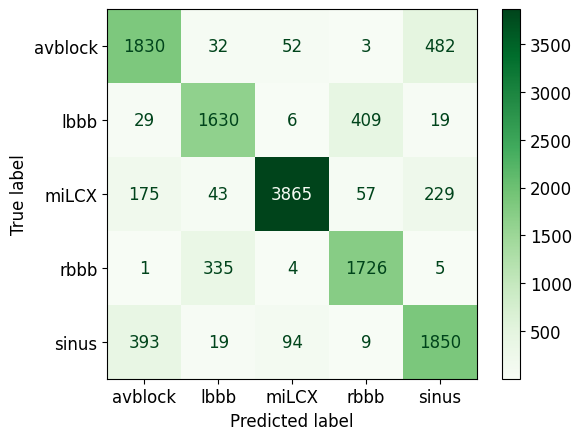

In [29]:
plt.figure(figsize=(12,12))
cm, classes, predictions = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train, y_test,
    KNeighborsClassifier(n_neighbors=best_k),
    '../analysis/media/confusion_matrix_multiclass_medalcare_diagnostic.png',
    dpi=DPI,
)

In [30]:
Helper.calculate_f1(cm, include)

{'Macro F1': 0.8039387510277631,
 'Precision': {'avblock': 0.7537067545304778,
  'lbbb': 0.7916464303059738,
  'miLCX': 0.9612036806764487,
  'rbbb': 0.7831215970961888,
  'sinus': 0.7156673114119922},
 'Recall': {'avblock': 0.7628178407669862,
  'lbbb': 0.7787864309603441,
  'miLCX': 0.884641794460975,
  'rbbb': 0.8334138097537421,
  'sinus': 0.7822410147991543},
 'F1 Scores': {'avblock': 0.7582349285270353,
  'lbbb': 0.7851637764932563,
  'miLCX': 0.9213349225268176,
  'rbbb': 0.807485380116959,
  'sinus': 0.7474747474747475}}

In [31]:
Visualizations.print_metrics_multiclass(cm, y_test, predictions)

Accuracy:   	 0.8198089794690532 

Weighted F1 Score:   	 0.8218203846173129 



### Binary

As with multi-class prediction, the same approach was followed for binary classification, i.e. the "sinus" samples were separated from the "rbbb", "lbbb" and "avblock" classes.

In [32]:
best_k = Helper.cross_validation_knn(X_train, X_val, y_train_b, y_val_b)

Best k: 5 with accuracy: 0.9227865232566422


<Figure size 1500x1500 with 0 Axes>

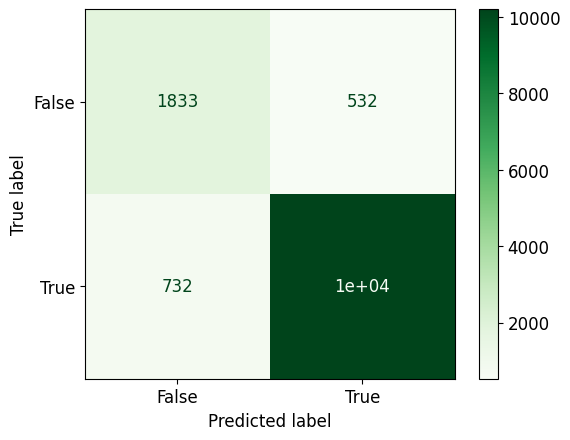

In [33]:
cm, classes, predictions_b = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train_b, y_test_b,
    KNeighborsClassifier(n_neighbors=best_k),
    '../analysis/media/confusion_matrix_binary_medalcare_diagnostic.png',
    dpi=DPI,
)

In [35]:
Visualizations.print_metrics_binary(cm, y_test_b, predictions_b)

Accuracy:   	 0.9049409641272468 

Sensitivity:	 0.7146198830409357 

Specificity:	 0.9504286246738726 

F1 Score:	 0.9416543574593795 



### Interpretation

Finally, we would like to use distribution diagrams to investigate how well the pathologies can be separated along the explainable axis.

In [36]:
pair_df = df_medalcare_test[df_medalcare_test.diagnosis.isin(include)].loc[:, list([3, 4, 6, 10]) + ['diagnosis']]

In [37]:
pair_df.diagnosis = pair_df.diagnosis.replace('sinus', 'Sinus').replace('rbbb', 'RBBB').replace('lbbb', 'LBBB').replace('avblock', 'AVBlock').replace('miLCX', 'MI LCX')

In [38]:
cols = {'diagnosis': 'Diagnosis'}
pair_df = pair_df.rename(columns=cols)

In [39]:
palette = {'Sinus': 'tab:orange', 'MI LCX': 'tab:blue', 'LBBB': 'tab:purple', 'RBBB': 'tab:green', 'AVBlock': 'tab:red'}

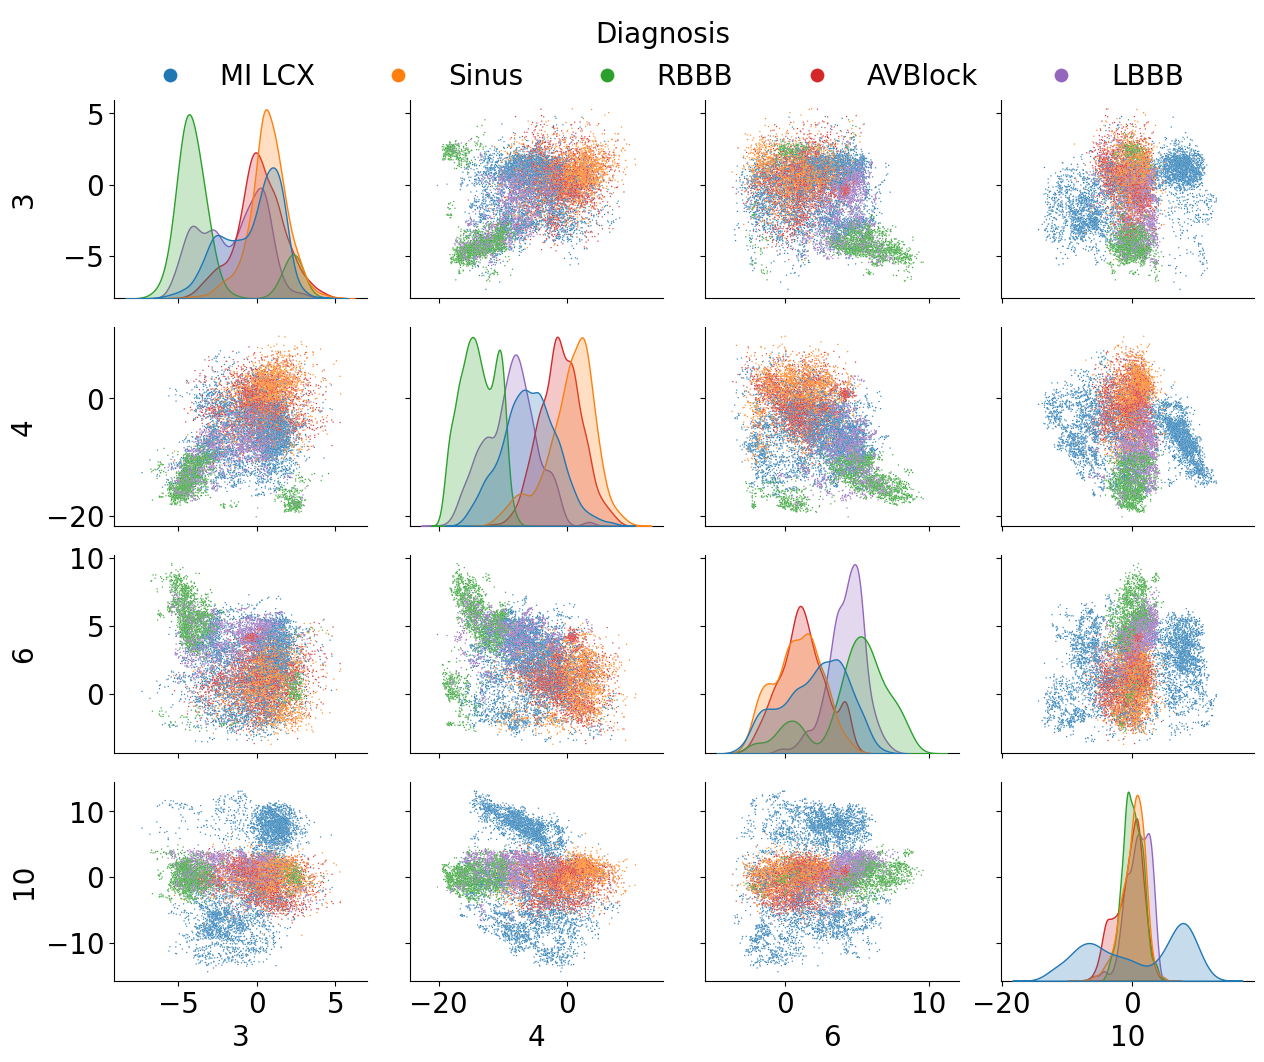

In [41]:
plt.rcParams['font.size'] = 20
pairplot = sns.pairplot(pair_df, hue="Diagnosis", plot_kws={"s": 1}, diag_kws={'common_norm': False}, palette=palette, aspect=1.3)

for handle in pairplot._legend.legendHandles:
    handle.set_markersize(10)
sns.move_legend(pairplot, "upper center", bbox_to_anchor=(.45, 1.08), ncol=5, frameon=False)
for ax in pairplot.axes[:, 0]:
    ax.yaxis.set_label_coords(-0.3, 0.5)

pairplot.savefig('../analysis/media/anomaly_interpretation_medalcare.png', dpi=DPI)

## 3. Personalization

The subjects from the _icentia11k_ data set are used for personalization. For each of the 100 subjects randomly selected from the total dataset, the base model is fine-tuned and the embedding is saved. From the 100 randomly selected samples of the icentia11k dataset, a set of 6 subjects was selected for the analysis of the distribution graphs. 3 samples were selected because they contained a large number of PAC samples, while the other 3 samples were selected because of the frequent occurrence of PVC. All 6 samples also had a high number of normal class ECG beats. A custom color palette is defined for the classes Normal, PVC, and PAC to adhere to consisting coloring throughout the evaluation.

In [42]:
from src.evaluate.personalization import fine_tune

In [43]:
datasets = {
    'name': ['icentia11k'],
    'shuffle_size': 1024,
    'batch_size': 1024,
}

splits = [
    '107', '5484', '6998', '3984', '3111', '4040', '3013', '6607', '4219', '8750', '5665', '9225',
    '8030', '9886', '1851', '1123', '3043', '3369', '6829', '10969', '3088', '9405', '9535', '4993',
    '4209', '10937', '6167', '4688', '6877', '10733', '8412', '10146', '10973', '9345', '2514', '2908',
    '5938', '5015', '9595', '8769', '4786', '2602', '7779', '2826', '1118', '3485', '2980', '10503',
    '7719', '6575', '1722', '7234', '8366', '3948', '5493', '10731', '8111', '2820', '5337', '5369',
    '4184', '9403', '9625', '303', '33', '3274', '1941', '9116', '9283', '3522', '4836', '7107', '251',
    '9071', '6899', '9733', '9440', '457', '2954', '1839', '5865', '8500', '9559', '1277', '1145', '10107',
    '9287', '8443', '9783', '9956', '10090', '3204', '6814', '4553', '6377', '5572', '1178', '5032', '1793', '4453',
]

subjects = ['2602', '9225', '10973', '1851', '5938', '10146']
# use a custom order to stay consistent in the order of presentation
custom_sort_order = [2602, 9225, 10973, 1851, 5938, 10146]

palette = {'Normal': 'C0', 'PVC': 'C2', 'PAC': 'C1'}

ld = 12
path_save = '../analysis/personalization/embeddings_vae/'

In [44]:
if not USE_PRECOMPUTED:
    fine_tune(path_model, datasets, splits, ld, path_save)

### Personlized Models: Accuracy

Let's load the emebddings from the personalzed computations and train a kNN on the train set (80 % of the complete dataset) and save the confusion matrix based on the test set (remaining 20 %).

In [45]:
def plot_confustion_matrix(X_train, X_test, y_train, y_test, predictor, path, dpi, normalize=False, cmap='Greens'):
        predictor.fit(X_train.fillna(0), y_train)
        predictions = predictor.predict(X_test.fillna(0))
        cm = confusion_matrix(y_test, predictions, labels=predictor.classes_)
        return cm, predictor.classes_, predictions

In [46]:
if not USE_PRECOMPUTED:
    for k in glob.glob('../analysis/personalization/embeddings_vae/*.csv'):
        try:
            df_pers = pd.read_csv(k)
            df_pers["beat_b"] = df_pers.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'Anomal').replace(3.0, 'Anomal')
            df_pers.beat = df_pers.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
            df_pers = df_pers[df_pers.beat != 'Unclassified'].drop('Unnamed: 0', axis=1)
            
            X_train, X_test, y_train, y_test = train_test_split(
                        df_pers.iloc[:, :ld],
                        df_pers.beat,
                        test_size=0.2,
                        random_state=42,
                        stratify=df_pers.beat,
                    )
            cm, classes, prediction = plot_confustion_matrix(
                        X_train, X_test, y_train, y_test,
                        KNeighborsClassifier(n_neighbors=13),
                        '../analysis/media/test.png',
                        dpi=10,
                    )
            pred_df = pd.DataFrame(cm, columns=classes, index=classes)
            pred_df.to_csv('../analysis/personalization/confusion_matrices/' + k.split('/')[-1])
            
            if df_pers.groupby('beat_b')['beat_b'].count()['Anomal'] > 500:
                X_train, X_test, y_train, y_test = train_test_split(
                        df_pers.iloc[:, :ld],
                        df_pers.beat_b,
                        test_size=0.2,
                        random_state=42,
                        stratify=df_pers.beat_b,
                    )
                cm, classes, prediction = plot_confustion_matrix(
                        X_train, X_test, y_train, y_test,
                        KNeighborsClassifier(n_neighbors=13),
                        '../analysis/media/test.png',
                        dpi=10,
                    )
                pred_df = pd.DataFrame(cm, columns=classes, index=classes)
                pred_df.to_csv('../analysis/personalization/confusion_matrices_b/' + k.split('/')[-1])
        except Exception as e:
            print('Skipped', e)
            continue

There are two ways to merge the confusion matrices to evaluate the overall goodness of fit. Therefore, we load the confusion matrices and:
1. sum them element by element and then normalize them per row
2. normalize them per subject and row and then sum them together

Both versions offer a different view of the matter. However, the latter (2) offers a more unbiased way to evaluate performance, as highly unbalanced class distributions are not as significant.

In [49]:
df = pd.DataFrame()
df_unbiased = pd.DataFrame()
files = glob.glob('../analysis/personalization/confusion_matrices/*.csv')
files_b = glob.glob('../analysis/personalization/confusion_matrices_b/*.csv')
individual_f1_scores = []
index_and_columns = ['Normal', 'PAC', 'PVC']
index_and_columns_b = ['Normal', 'Anomal']

for i, k in enumerate(files):
    temp = pd.read_csv(k, index_col=0)
    temp = temp.reindex(index=index_and_columns, columns=index_and_columns, fill_value=0)
    df = df.add(temp, fill_value=0)

for i, k in enumerate(files_b):
    temp = pd.read_csv(k, index_col=0)
    temp = temp.reindex(index=index_and_columns_b, columns=index_and_columns_b, fill_value=0)
    individual_f1_result = Helper.calculate_f1(temp.to_numpy(), temp.columns)
    individual_f1_scores.append(individual_f1_result)

In [50]:
Helper.calculate_f1(df.to_numpy(), df.columns)

{'Macro F1': 0.9289646445030383,
 'Precision': {'Normal': 0.9977836107830523,
  'PAC': 0.8935329003106467,
  'PVC': 0.9565256525652566},
 'Recall': {'Normal': 0.9989265169401321,
  'PAC': 0.778871852581235,
  'PVC': 0.9560093558834113},
 'F1 Scores': {'Normal': 0.998354736764918,
  'PAC': 0.832271762208068,
  'PVC': 0.956267434536129}}

In [51]:
avg_metrics_b = {
    'Macro F1': 0,
    'Precision': {'Normal': 0, 'Anomal': 0},
    'Recall': {'Normal': 0, 'Anomal': 0},
    'F1 Scores': {'Normal': 0, 'Anomal': 0},
}

In [52]:
Helper.average_metrics(individual_f1_scores, avg_metrics_b)

{'Macro F1': 0.8719371762878977,
 'Precision': {'Normal': 0.9953409864569436, 'Anomal': 0.8911085073225115},
 'Recall': {'Normal': 0.997535667247116, 'Anomal': 0.6899397783559971},
 'F1 Scores': {'Normal': 0.9964342500495196, 'Anomal': 0.7474401025262758}}

### Personlized Models: Inter-subject patterns

We load the embedding (of the base model) of all subjects from the convenience sample and embed them in a 2-dimensional space using TSNE. Due to computational limitations, only a small portion (20%) of the total available data is used. However, the uniform subsample should capture the overall distribution well enough.

In [53]:
if not USE_PRECOMPUTED:
    df = Helper.get_icentia_embedding(subjects, model)
    X_train, X_test, y_train, y_test = train_test_split(
            df,
            df.subject,
            test_size=0.2,
            random_state=42,
            stratify=df.subject,
        )
    
    X_embedded = TSNE(n_components=2).fit_transform(X_test.iloc[:,:ld].fillna(0.0))
    X_embedded = pd.DataFrame(X_embedded, columns=['Projected Axis 1', 'Projected Axis 2'])
    X_embedded['Beat'] = X_test.beat.values
    X_embedded['Subject'] = y_test.values
    X_embedded.to_csv('../analysis/personalization/embeddings_tsne/all.csv')
else:
    X_embedded = pd.read_csv('../analysis/personalization/embeddings_tsne/all.csv')

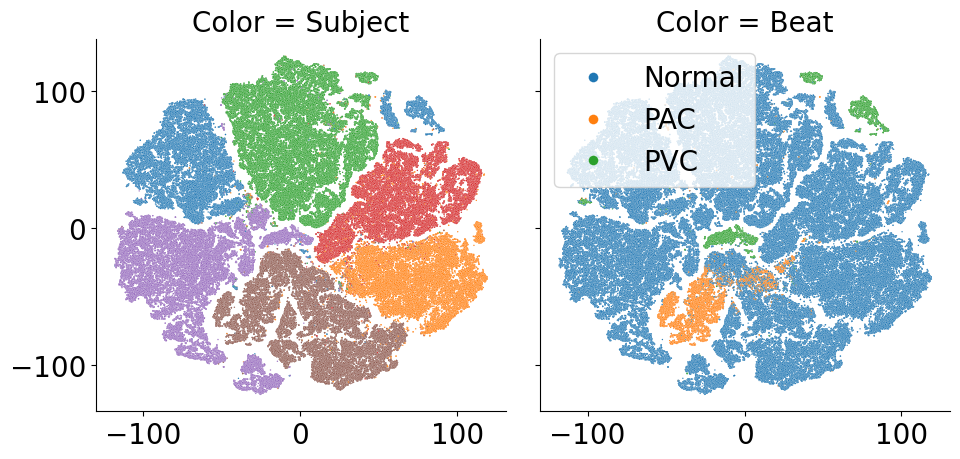

In [54]:
df_melted = pd.melt(X_embedded, id_vars=['Projected Axis 1', 'Projected Axis 2'], 
                    value_vars=['Subject', 'Beat'], 
                    var_name='Color', value_name='Color_')

g = sns.FacetGrid(df_melted, col='Color', height=5, aspect=1)

g.map(sns.scatterplot, 'Projected Axis 1', 'Projected Axis 2', 'Color_', s=1, palette='tab10')

g.set_axis_labels("","")

for i, ax in enumerate(g.axes.flat):
    if i == 0:
        ax.set_yticks([-100, 0, 100])

plt.legend(markerscale=7, loc='upper left')
plt.tight_layout()
fig = g.figure
fig.savefig('../analysis/media/embedding_icentia.png' , dpi=DPI, bbox_inches = 'tight')

Since we have seen a strong clustering behavior with respect to the subjects, we would like to investigate the individual embeddings based on their personalized Mdoels. Therefore, we load the subjects' personalized embeddings and embed them individually (i.e., unlike in the previous calculation, all together but each one separately) into 2-dimensional points with TSNE.

In [55]:
if not USE_PRECOMPUTED:
    for subject in subjects:
        print(subject)
        df = pd.read_csv('../analysis/personalization/embeddings_vae/' + str(subject) + '.csv', index_col=0)
        X_embedded = TSNE(n_components=2).fit_transform(df.iloc[:, 0:ld])
        X_embedded = pd.DataFrame(X_embedded, columns=['Projected Axis 1', 'Projected Axis 2'])
        X_embedded['beat'] = df.beat
        X_embedded['segment'] = df.segment
        X_embedded.beat = X_embedded.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
        X_embedded = X_embedded[X_embedded.beat != 'Unclassified']
        cols = {'beat': 'Beat'}
        X_embedded = X_embedded.rename(columns=cols)
        X_embedded.to_csv('../analysis/personalization/embeddings_tsne_small/' + str(subject) + '.csv')

In [56]:
df = pd.DataFrame()
for path in glob.glob('../analysis/personalization/embeddings_tsne_small/*.csv'):
    subject = path.split('/')[-1][:-4]
    if subject != 'all':
        X_embedded = pd.read_csv(path, index_col=0)
        X_embedded['subject'] = subject
        df = pd.concat([df, X_embedded])
df.reset_index(drop=True, inplace=True)
cols = {'subject': 'Subject'}
df = df.rename(columns=cols)
df.Subject = df.Subject.astype(int)
df['Subject'] = pd.Categorical(df['Subject'], categories=custom_sort_order, ordered=True)

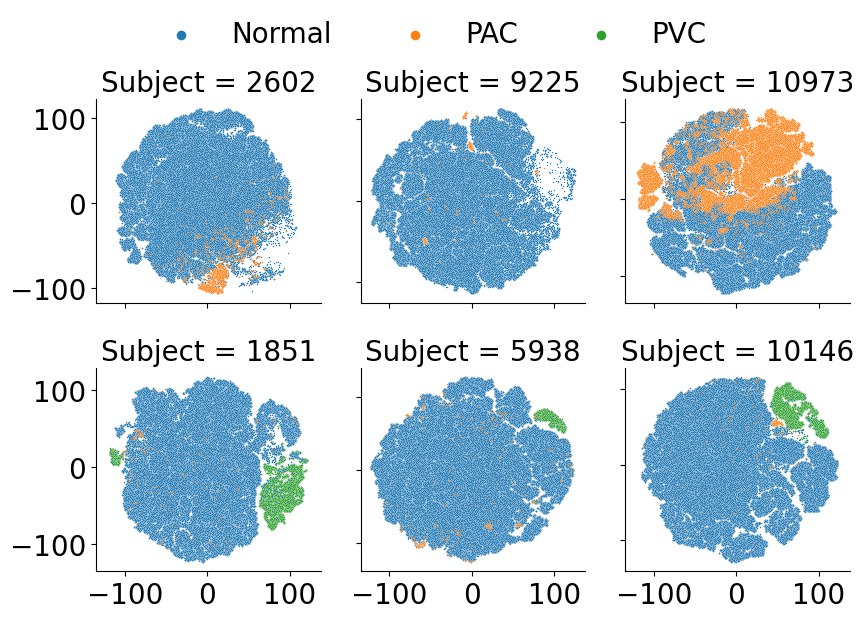

In [60]:
g = sns.FacetGrid(df, col="Subject", col_wrap=3, palette=palette, hue="Beat", sharex=True, sharey=False)
g.map(sns.scatterplot, "Projected Axis 1", "Projected Axis 2", s=1)
g.set_axis_labels("", "")

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i % 3 != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

g.fig.subplots_adjust(wspace=0.1, hspace=0.01)

handles, labels = g.axes[0].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, markerscale=7, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, borderaxespad=0., edgecolor='white')

plt.tight_layout()
fig = g.figure

fig.savefig('../analysis/media/tsne_embedding_personalization.png', dpi=DPI, bbox_inches='tight')

### Personalized Models: Explainability Pathologies along the axis

For this experiment, we reload the embeddings of the personalized models. We expect a separating behavior on the fourth dimension, which is related to the S-wave, the Q-wave and thus the width of the QRS complex, one of the most important morphological changes in PVC. The same applies to the P wave and the PAC. The convincingly selected subjects who had either a high number (for significance) of PAC or PVCs were used to create the diagram. 

In [61]:
df_pers = pd.DataFrame()
for k in subjects:
    df_per = pd.read_csv('../analysis/personalization/embeddings_vae_small/' + k + '.csv')
    df_per.beat = df_per.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
    df_per = df_per[df_per.beat != 'Unclassified'].drop('Unnamed: 0', axis=1)
    df_pers = pd.concat([df_pers, df_per])
df_pers.reset_index(drop=True, inplace=True)
cols = {
    'split': 'Subject', 'beat': 'Beat', #'4': 'S-wave and Q-Wave (width)', '5': 'P-wave (height, width)', 
}
df_pers = df_pers.rename(columns=cols)
df_pers.Subject = df_pers.Subject.astype(int)
df_pers.reset_index(drop=True, inplace=True)

In [62]:
df_pers_pac = df_pers[df_pers.Subject.isin([2602, 9225, 10973])]
df_pers_pvc = df_pers[df_pers.Subject.isin([1851, 5938, 10146])]

In [63]:
df_pers_pac = df_pers_pac.sort_values('Subject')
df_pers_pvc = df_pers_pvc.sort_values('Subject')

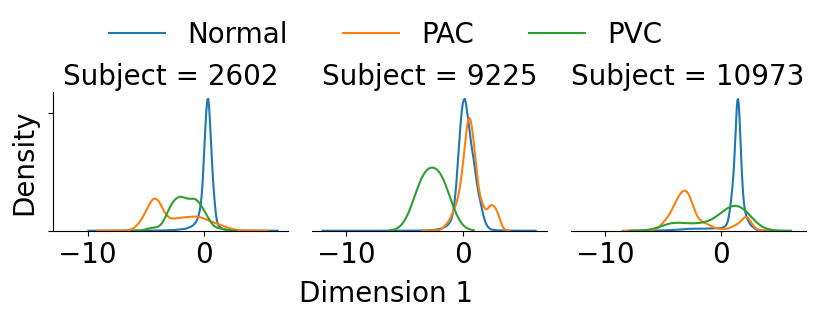

In [66]:
g = sns.FacetGrid(df_pers_pac, col="Subject", col_wrap=3, hue="Beat", palette=palette, sharey=False, aspect=1)
g.map(sns.kdeplot, "1", common_norm=False, warn_singular=False)

handles, labels = g.axes[0].get_legend_handles_labels()

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i == 0:
        ax.set_yticklabels([])
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False) 

sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=3, borderaxespad=0., edgecolor='white')
g.fig.text(0.5, 0.1, 'Dimension 1', ha='center')
g.fig.subplots_adjust(wspace=0.1)
plt.show()

fig = g.fig
fig.savefig('../analysis/media/distribution_pac.png', dpi=DPI, bbox_inches='tight')

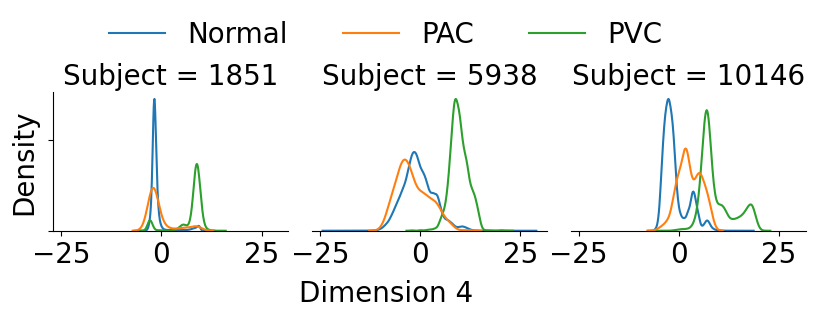

In [67]:
g = sns.FacetGrid(df_pers_pvc, col="Subject", col_wrap=3, hue="Beat", palette=palette, sharey=False, aspect=1)
g.map(sns.kdeplot, "4", common_norm=False, warn_singular=False)

handles, labels = g.axes[0].get_legend_handles_labels()

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i == 0:
        ax.set_yticklabels([])
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False) 

sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=3, borderaxespad=0., edgecolor='white')
g.fig.text(0.5, 0.1, 'Dimension 4', ha='center')
g.fig.subplots_adjust(wspace=0.1)
plt.show()

# Save the figure
fig = g.fig
fig.savefig('../analysis/media/distribution_pvc.png', dpi=DPI, bbox_inches='tight')

Finally, for all subjects and all axis, the distribution plot is generated. Note, that for several subjects there is a strong class imbalance.

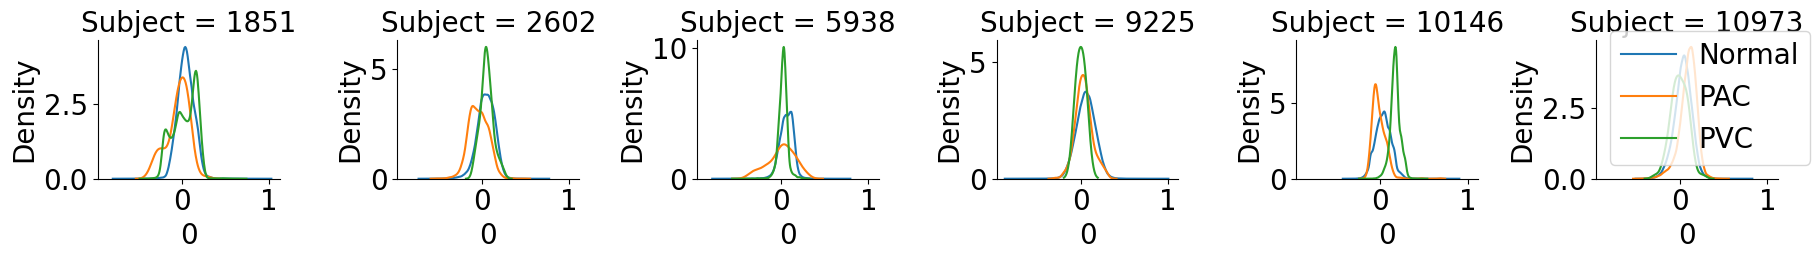

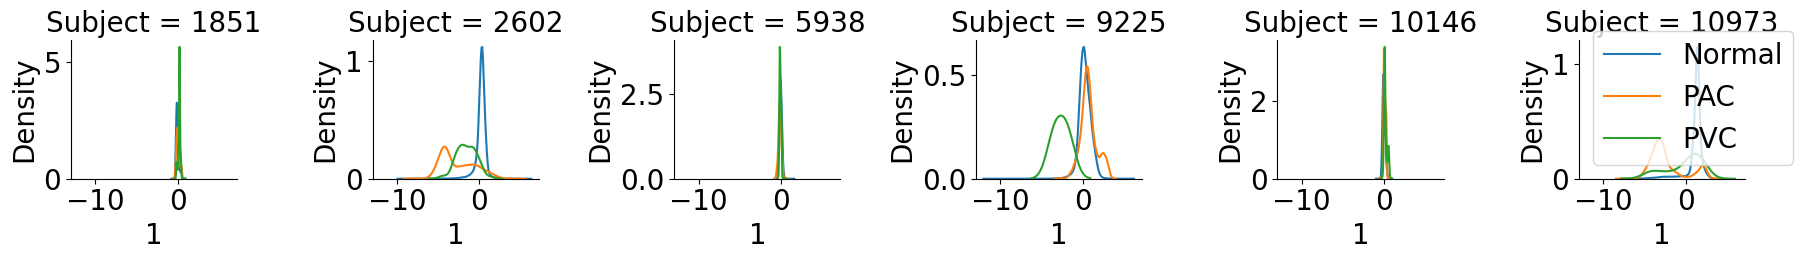

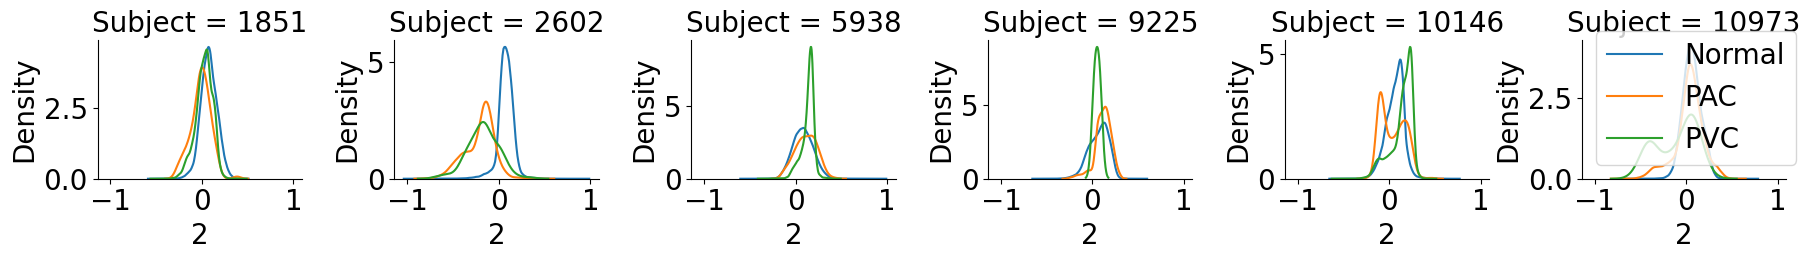

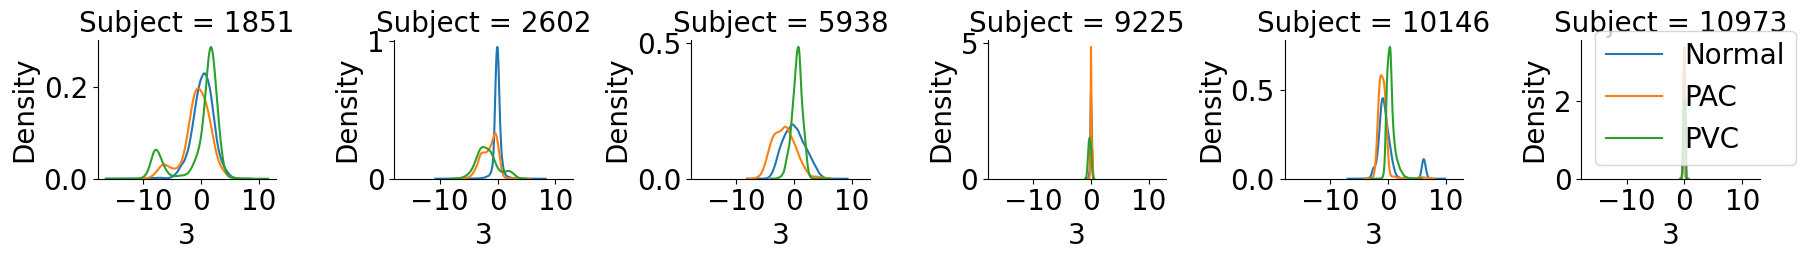

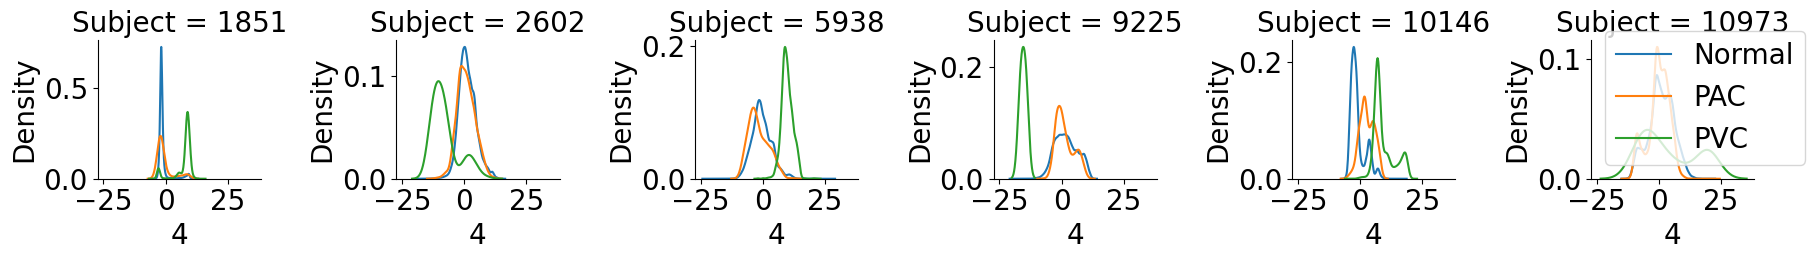

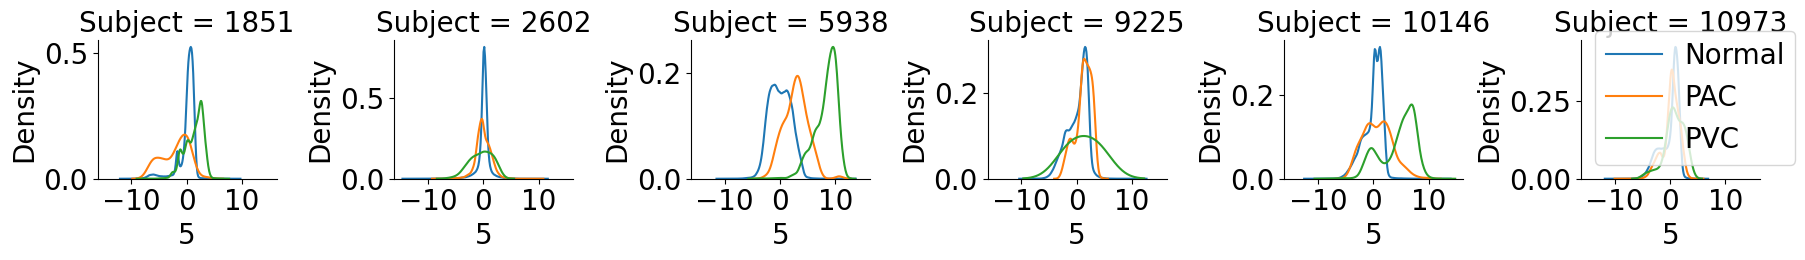

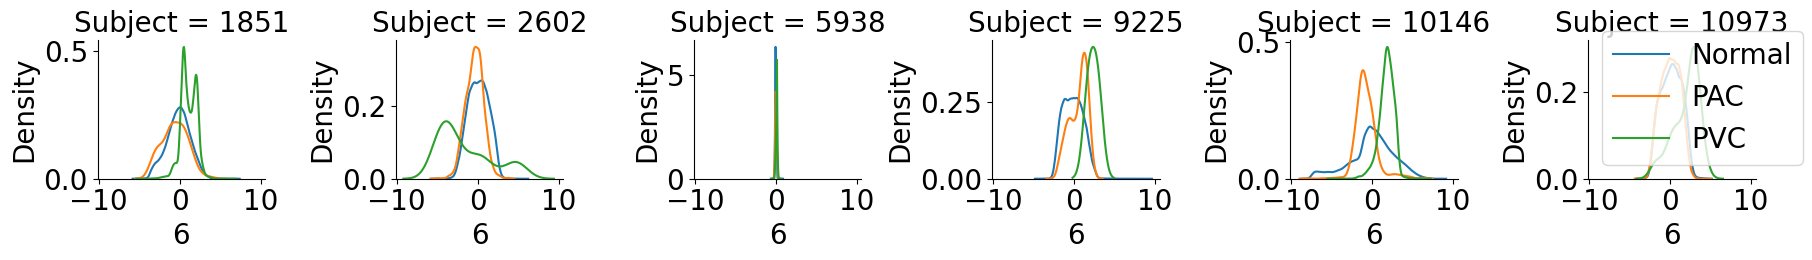

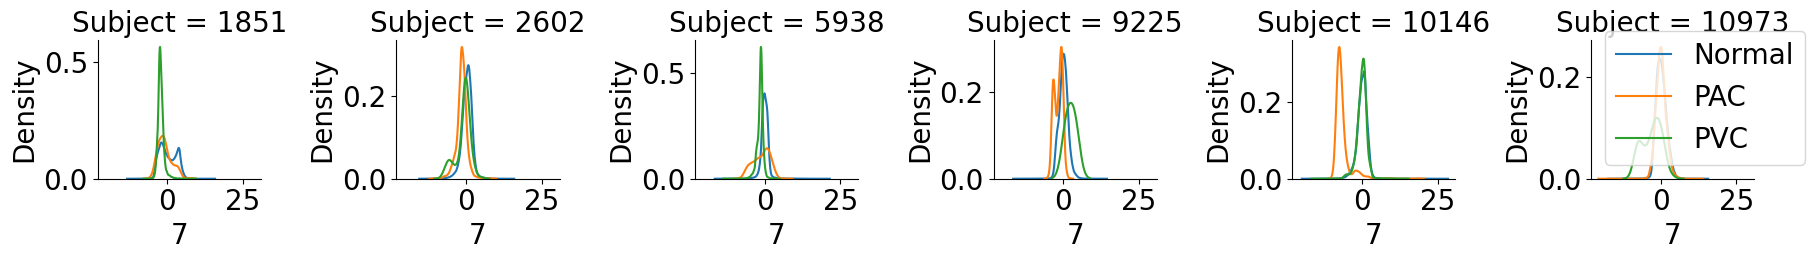

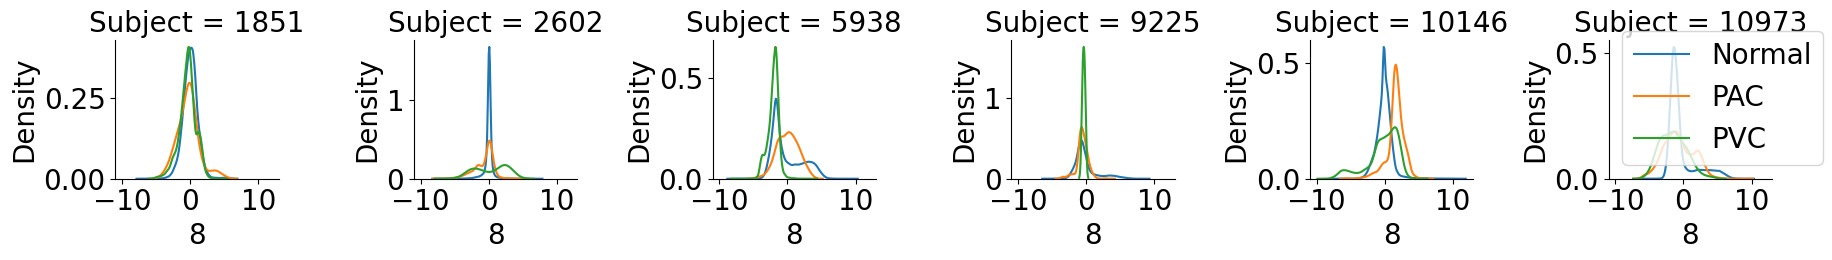

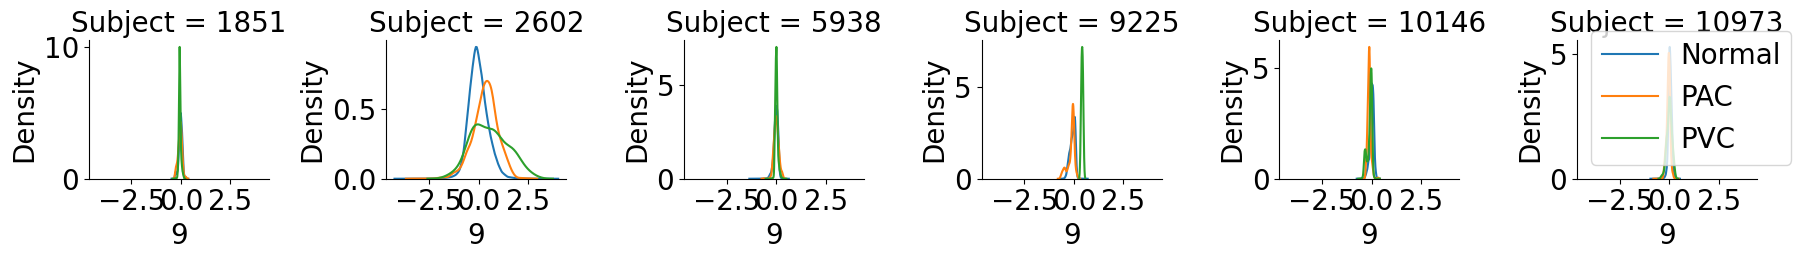

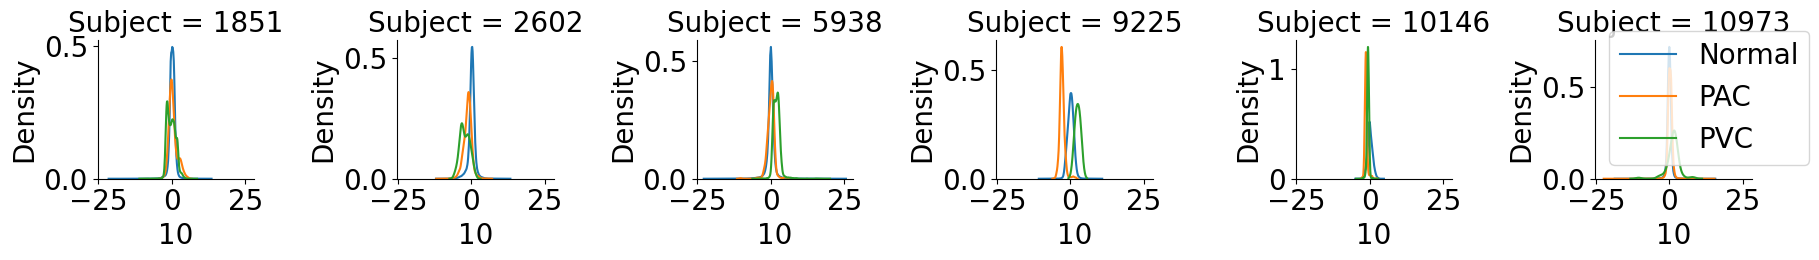

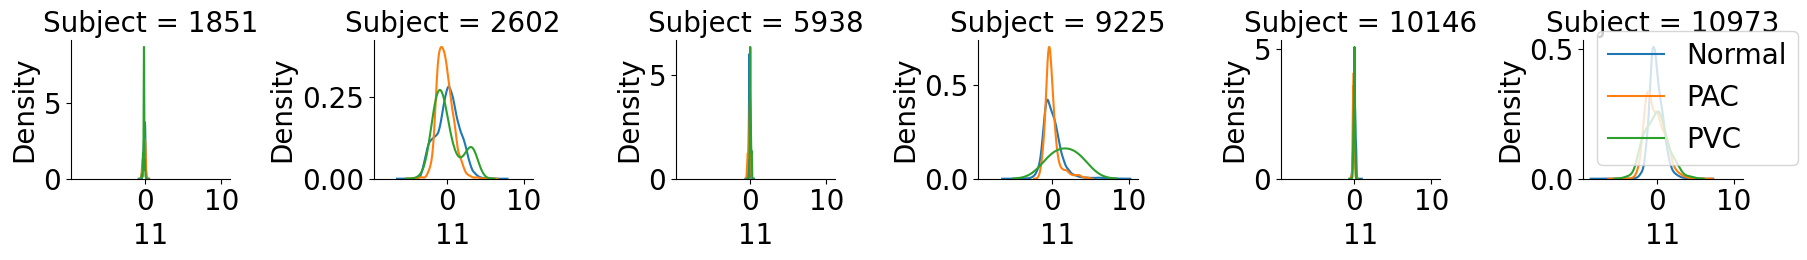

In [68]:
for i, k in enumerate(df_pers.columns[:ld]):
    g = sns.FacetGrid(df_pers, col="Subject", col_wrap=9, hue="Beat", sharey=False, palette=palette)
    g.map(sns.kdeplot, k, common_norm=False, warn_singular=False)
    plt.legend()
    fig = g.figure
    fig.savefig('../analysis/media/distribution_personalization_all_' + str(i) + '.png' , dpi=300, bbox_inches = 'tight')